# Tuning KNN models and testing them against external datasets

## Setting up

In [3]:
# setting up
# imports
import pyreadr
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.neighbors import KNeighborsRegressor as KNN

# calculate the mean of the pearson coefficients of multiple variables
def pair_pearsonr(x, y, axis=0): # this will allow us to take the pearson coefficient across two variables
    mx = np.mean(x, axis=axis, keepdims=True)
    my = np.mean(y, axis=axis, keepdims=True)
    xm, ym = x-mx, y-my
    r_num = np.add.reduce(xm * ym, axis=axis)
    r_den = np.sqrt((xm*xm).sum(axis=axis) * (ym*ym).sum(axis=axis))
    r = r_num / r_den
    return r

# plotting setup
# Use LaTeX for graphs' text
plt.rc('text', usetex=True)
# Use the serif font
plt.rc('font', family='serif')

In [7]:
# import data, access pandas df via key "None"
X_Govaere = pyreadr.read_r("datasets/X_Govaere.rds")[None]
X_Hoang = pyreadr.read_r("datasets/X_Hoang.rds")[None]
X_Pantano = pyreadr.read_r("datasets/X_Pantano.rds")[None]

# actual, clinical results
Y_Govaere = pyreadr.read_r("datasets/Y_Govaere.rds")[None]
Y_Hoang = pyreadr.read_r("datasets/Y_Hoang.rds")[None]
Y_Pantano = pyreadr.read_r("datasets/Y_Pantano.rds")[None]

# viper metric, predicted results
Y_viper_Govaere = pyreadr.read_r("datasets/viper_X_Govaere.rds")[None]
Y_viper_Hoang = pyreadr.read_r("datasets/viper_X_Hoang.rds")[None]
Y_viper_Pantano = pyreadr.read_r("datasets/viper_X_Pantano.rds")[None]

In [123]:
# setup tuning procedure
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
num_neighbors = [2,3,5,10,15,20]

# select our training dataset
# TODO: CHANGE THE FOLLOWING 3 LINES
training_dataset = "Hoang"
X = X_Hoang
Y = Y_Hoang

## Perform cross validation to find ideal number of latent variables

In [125]:
pearson_coeff_neighbors = [] # containing tuples (num_neighbors, avg pearson coeff)

for neighbors in num_neighbors:
    
    pearson_coeff = []

    # index into one column only because we need the correct dim for finding indices
    for i, (train_index, test_index) in enumerate(skf.split(X, Y[Y.columns[0]])):

        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        Y_train = Y.iloc[train_index]
        Y_test = Y.iloc[test_index]

        model = KNN(n_neighbors=neighbors)
        model.fit(X_train, Y_train)
        Y_test_hat = model.predict(X_test)

        # take the mean in order to be able to generalize the behavior on both phenotypes
        pearson_coeff.append(np.mean(pair_pearsonr(Y_test.values, Y_test_hat)))
    
    # evaluate the hyperparameter based on the average pearson coeff across all 10 folds
    pearson_coeff_neighbors.append((neighbors, sum(pearson_coeff)/len(pearson_coeff)))

# print the result of the hyperparameter optimization
print(f'From 10-fold cross validation on {training_dataset} data, {max(pearson_coeff_neighbors, key=lambda x: x[1])[0]} neighbors achieves an average Pearson coeff of {max(pearson_coeff_neighbors, key=lambda x: x[1])[1]}.')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
/opt/anaconda3/lib/p

From 10-fold cross validation on Hoang data, 10 neighbors achieves an average Pearson coeff of 0.6693899907884641.


In [127]:
# save the model so we can run it again
# this time, store the pearson's coeff for training and validation sets

best_neighbors = max(pearson_coeff_neighbors, key=lambda x: x[1])[0]

neighbors = best_neighbors # our best performing hyperparameter
train_pearson_coeff = []
test_pearson_coeff = []

for i, (train_index, test_index) in enumerate(skf.split(X, Y[Y.columns[0]])):
    
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    Y_train = Y.iloc[train_index]
    Y_test = Y.iloc[test_index]

    model = KNN(n_neighbors=neighbors)
    model.fit(X_train, Y_train)
    
    Y_train_hat = model.predict(X_train) 
    train_pearson_coeff.append(np.mean(pair_pearsonr(Y_train.values, Y_train_hat)))
    
    Y_test_hat = model.predict(X_test) 
    test_pearson_coeff.append(np.mean(pair_pearsonr(Y_test.values, Y_test_hat)))
    
    filename = f"models/{training_dataset}_KNN_fold_{i}.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    
    print(f"Model for Fold {i} saved as {filename}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


Model for Fold 0 saved as models/Hoang_KNN_fold_0.pkl
Model for Fold 1 saved as models/Hoang_KNN_fold_1.pkl
Model for Fold 2 saved as models/Hoang_KNN_fold_2.pkl
Model for Fold 3 saved as models/Hoang_KNN_fold_3.pkl
Model for Fold 4 saved as models/Hoang_KNN_fold_4.pkl
Model for Fold 5 saved as models/Hoang_KNN_fold_5.pkl
Model for Fold 6 saved as models/Hoang_KNN_fold_6.pkl
Model for Fold 7 saved as models/Hoang_KNN_fold_7.pkl
Model for Fold 8 saved as models/Hoang_KNN_fold_8.pkl
Model for Fold 9 saved as models/Hoang_KNN_fold_9.pkl


In [129]:
# load all models
loaded_models = []
for i in range(0, 10):
    filename = f"models/{training_dataset}_KNN_fold_{i}.pkl"
    with open(filename, 'rb') as file:
        model = pickle.load(file)
        loaded_models.append(model)
    print(f"Loaded model {i} from {filename}")

Loaded model 0 from models/Hoang_KNN_fold_0.pkl
Loaded model 1 from models/Hoang_KNN_fold_1.pkl
Loaded model 2 from models/Hoang_KNN_fold_2.pkl
Loaded model 3 from models/Hoang_KNN_fold_3.pkl
Loaded model 4 from models/Hoang_KNN_fold_4.pkl
Loaded model 5 from models/Hoang_KNN_fold_5.pkl
Loaded model 6 from models/Hoang_KNN_fold_6.pkl
Loaded model 7 from models/Hoang_KNN_fold_7.pkl
Loaded model 8 from models/Hoang_KNN_fold_8.pkl
Loaded model 9 from models/Hoang_KNN_fold_9.pkl


## Test with the best model on external and shuffled datasets

In [131]:
# create shuffled dataset from training dataset
X_shuffled = X.apply(lambda col: np.random.permutation(col.values), axis=0)
X_shuffled.index = X.index # ensure the gene names are maintained

In [133]:
# run on the other two external test sets and the shuffled training dataset
# TODO: CHANGE THE FOLLOWING 6 LINES
X_test1 = X_Govaere
X_test2 = X_Pantano
Y_test1 = Y_Govaere
Y_test2 = Y_Pantano
test1 = "Govaere"
test2 = "Pantano"

test1_pearson_coeff = []
test2_pearson_coeff = []
shuffled_pearson_coeff = []

for i, model in enumerate(loaded_models):
    Y_pred = model.predict(X_test1)
    test1_pearson_coeff.append(np.mean(pair_pearsonr(Y_test1.values, Y_pred)))

    Y_pred = model.predict(X_test2)
    test2_pearson_coeff.append(np.mean(pair_pearsonr(Y_test2.values, Y_pred)))

    Y_pred = model.predict(X_shuffled)
    shuffled_pearson_coeff.append(np.mean(pair_pearsonr(Y.values, Y_pred)))


In [135]:
# store all pearson correlation coefficients in a dataframe
all_coeff = {
    'Train': train_pearson_coeff,
    'Validation': test_pearson_coeff,
    test1: test1_pearson_coeff,
    test2: test2_pearson_coeff,
    'Shuffled': shuffled_pearson_coeff
}

all_pearsons_coeff = pd.DataFrame(all_coeff)

## Plot with Mann-Whitney test

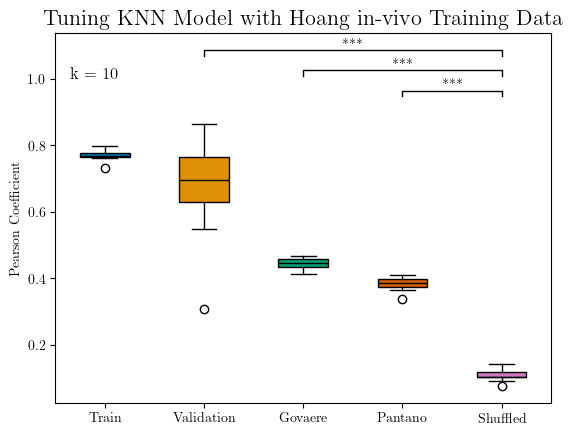

In [153]:
significant_combinations = []

combinations = [(x, 4) for x in [1, 2, 3]]
for combo in combinations:
    data1 = all_pearsons_coeff.iloc[:,combo[0]]
    data2 = all_pearsons_coeff.iloc[:,combo[1]]
    
    # calculate significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    if p < 0.05:
        significant_combinations.append([combo, p])

# create a set of axes
ax = plt.axes()
# create a boxplot on the axes
bp = ax.boxplot(all_pearsons_coeff, patch_artist=True)
# graph title TODO: CHANGE
ax.set_title(f"Tuning KNN Model with {training_dataset} in-vivo Training Data", fontsize=16)
# label y-axis
ax.set_ylabel("Pearson Coefficient")

xticklabels = all_pearsons_coeff.columns.tolist()
ax.set_xticklabels(xticklabels)

# Change the colour of the boxes to Seaborn's 'pastel' palette
colors = sns.color_palette('colorblind')
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Colour of the median lines
plt.setp(bp['medians'], color='k')

# Get the y-axis limits
bottom, top = ax.get_ylim()
y_range = top - bottom

# Significance bars
for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    # add one because the df indexing is 0 indexed, but plot is 1 indexed
    x1 = significant_combination[0][0] + 1 
    x2 = significant_combination[0][1] + 1
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

# label the hyperparameter value
plt.text(0.65, 1, f'k = {best_neighbors}', fontsize = 12)

#TODO: CHANGE
plt.savefig(f'graphs/KNN_tuning_with_{training_dataset}.png', dpi=200)
plt.show()

In [75]:
significant_combinations

[[(1, 4), 0.00018267179110955002],
 [(2, 4), 0.00018267179110955002],
 [(3, 4), 0.00018267179110955002]]